In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [2]:
bip_df = pd.read_csv(r'C:\Users\marco\OneDrive\Desktop\ADV Project\Graph_BS\graph_edges_TM.csv')

General Visualization

In [3]:
bip_df.head()

,user_id,post_id,interaction,date
0,953571,3078,created,05-30
1,953571,3079,reposted,05-30
2,953571,3104,created,05-24
3,953571,3105,created,05-23
4,953571,3131,created,05-18


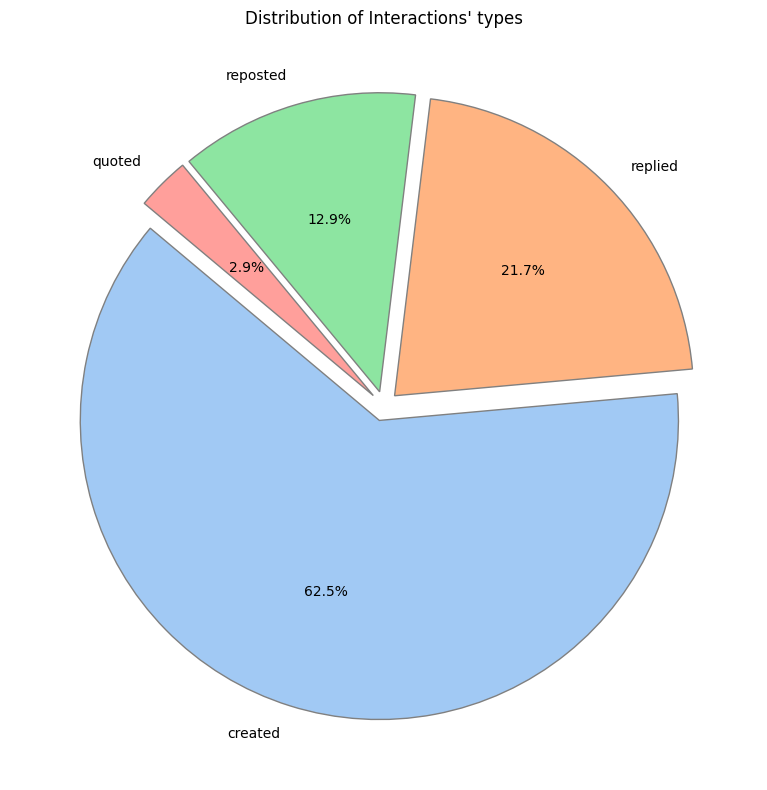

In [4]:
# Check the distribution of values in the 'interaction' column
interaction_counts = bip_df['interaction'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette("pastel")[0:len(interaction_counts)]  # Pastel colors
explode = [0.05] * len(interaction_counts)  # Slightly "explode" all slices

plt.pie(interaction_counts.values, 
        labels=interaction_counts.index, 
        autopct='%1.1f%%',  # Show percentages with one decimal place
        startangle=140,    # Start the first slice at 140 degrees
        colors=colors, 
        explode=explode,   # Add explosion effect
        wedgeprops={'edgecolor': 'gray', 'linewidth': 1})  # Enhance edge visibility

plt.title("Distribution of Interactions' types")
plt.tight_layout()
plt.show()

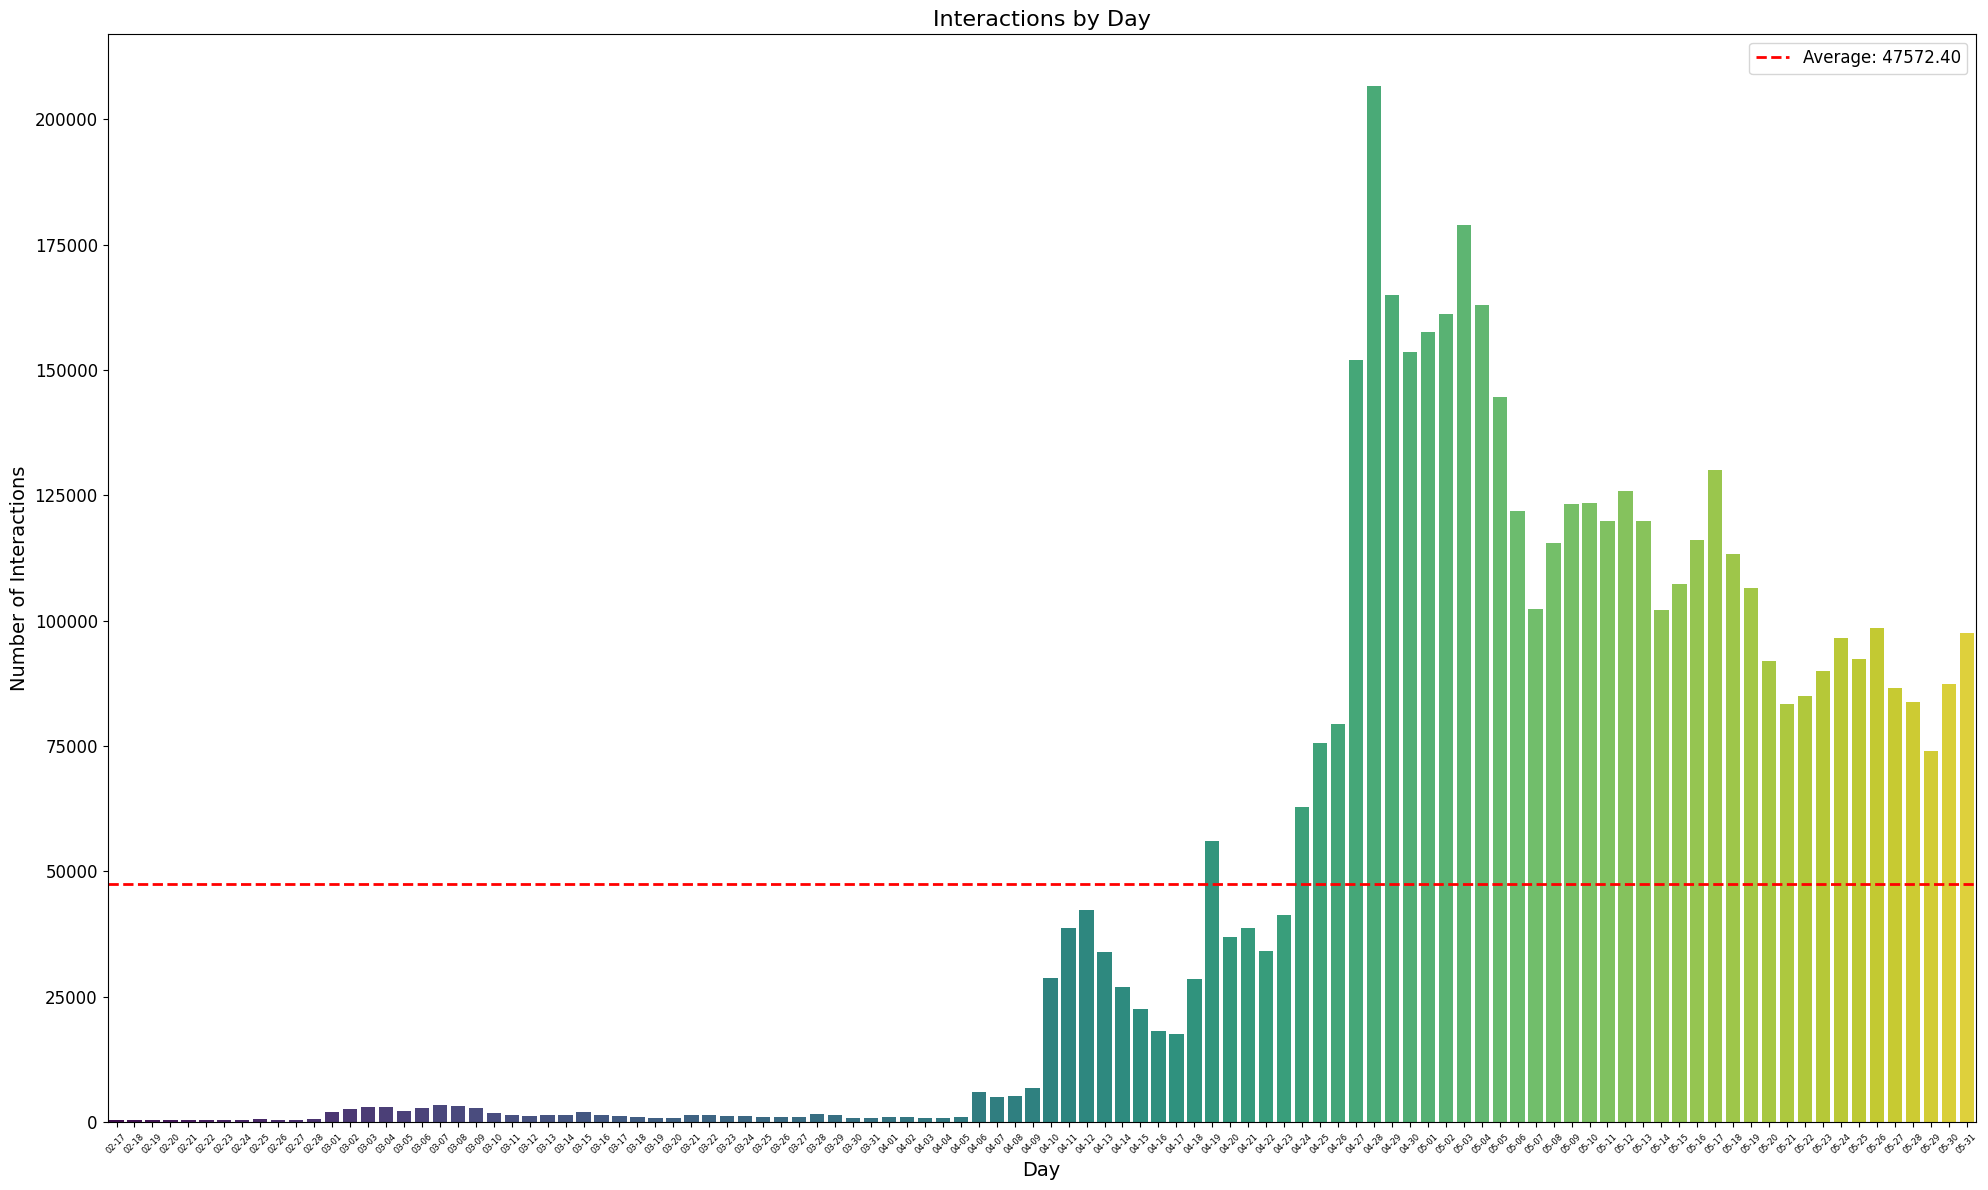

In [5]:
# Convert the 'date' column to datetime format using '%m-%d' (MM-DD)
bip_df['date'] = pd.to_datetime(bip_df['date'], format='%m-%d')

# Extract day from the 'date' column (keeping it as MM-DD format)
bip_df['day'] = bip_df['date'].dt.strftime('%m-%d')  # Format as MM-DD string

# Count interactions per day by grouping
interactions_per_day = bip_df.groupby('day').size().reset_index(name='interactions',)

# Calculate the average number of interactions per day
average_interactions = interactions_per_day['interactions'].mean()

# Plot the data using Seaborn
plt.figure(figsize=(20, 12))
sns.barplot(
    x='day', 
    y='interactions', 
    data=interactions_per_day,
    palette= 'viridis',
    hue='day'  # Fixed color to avoid palette warnings
)

# Add a red horizontal line to mark the average interactions
plt.axhline(average_interactions, color='red', linestyle='--', linewidth=2, label=f'Average: {average_interactions:.2f}')

# Adjust spacing between bars and add labels
plt.title("Interactions by Day", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Number of Interactions", fontsize=14)
plt.xticks(rotation=45, fontsize=6)  # Rotate x-axis labels for readability
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
# Filter for 'created' interactions only
created_interactions = bip_df[bip_df['interaction'] == 'created']

# Count the number of 'created' interactions per user (user_id)
user_interactions = created_interactions.groupby('user_id').size().reset_index(name='interaction_count')

# Calculate the average number of interactions per user
average_interactions = user_interactions['interaction_count'].mean()

# Get the top 10 most prolific users
top_10_users = user_interactions.sort_values(by='interaction_count', ascending=False).head(10)

# Print the average and the top 10 users
print(f"Average number of interactions per user: {average_interactions:.2f}")
print("\nTop 10 most prolific users:")
print(top_10_users)

Average number of interactions per user: 36.51

Top 10 most prolific users:
       user_id  interaction_count
294       1280              18214
287       1248              13699
2369     16369              12893
18231   151428              11525
6047     33502               9328
6022     33459               9193
2820     19242               9156
42628   530401               8991
408       2042               7444
6357     34184               7367


Clustering Analysis

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


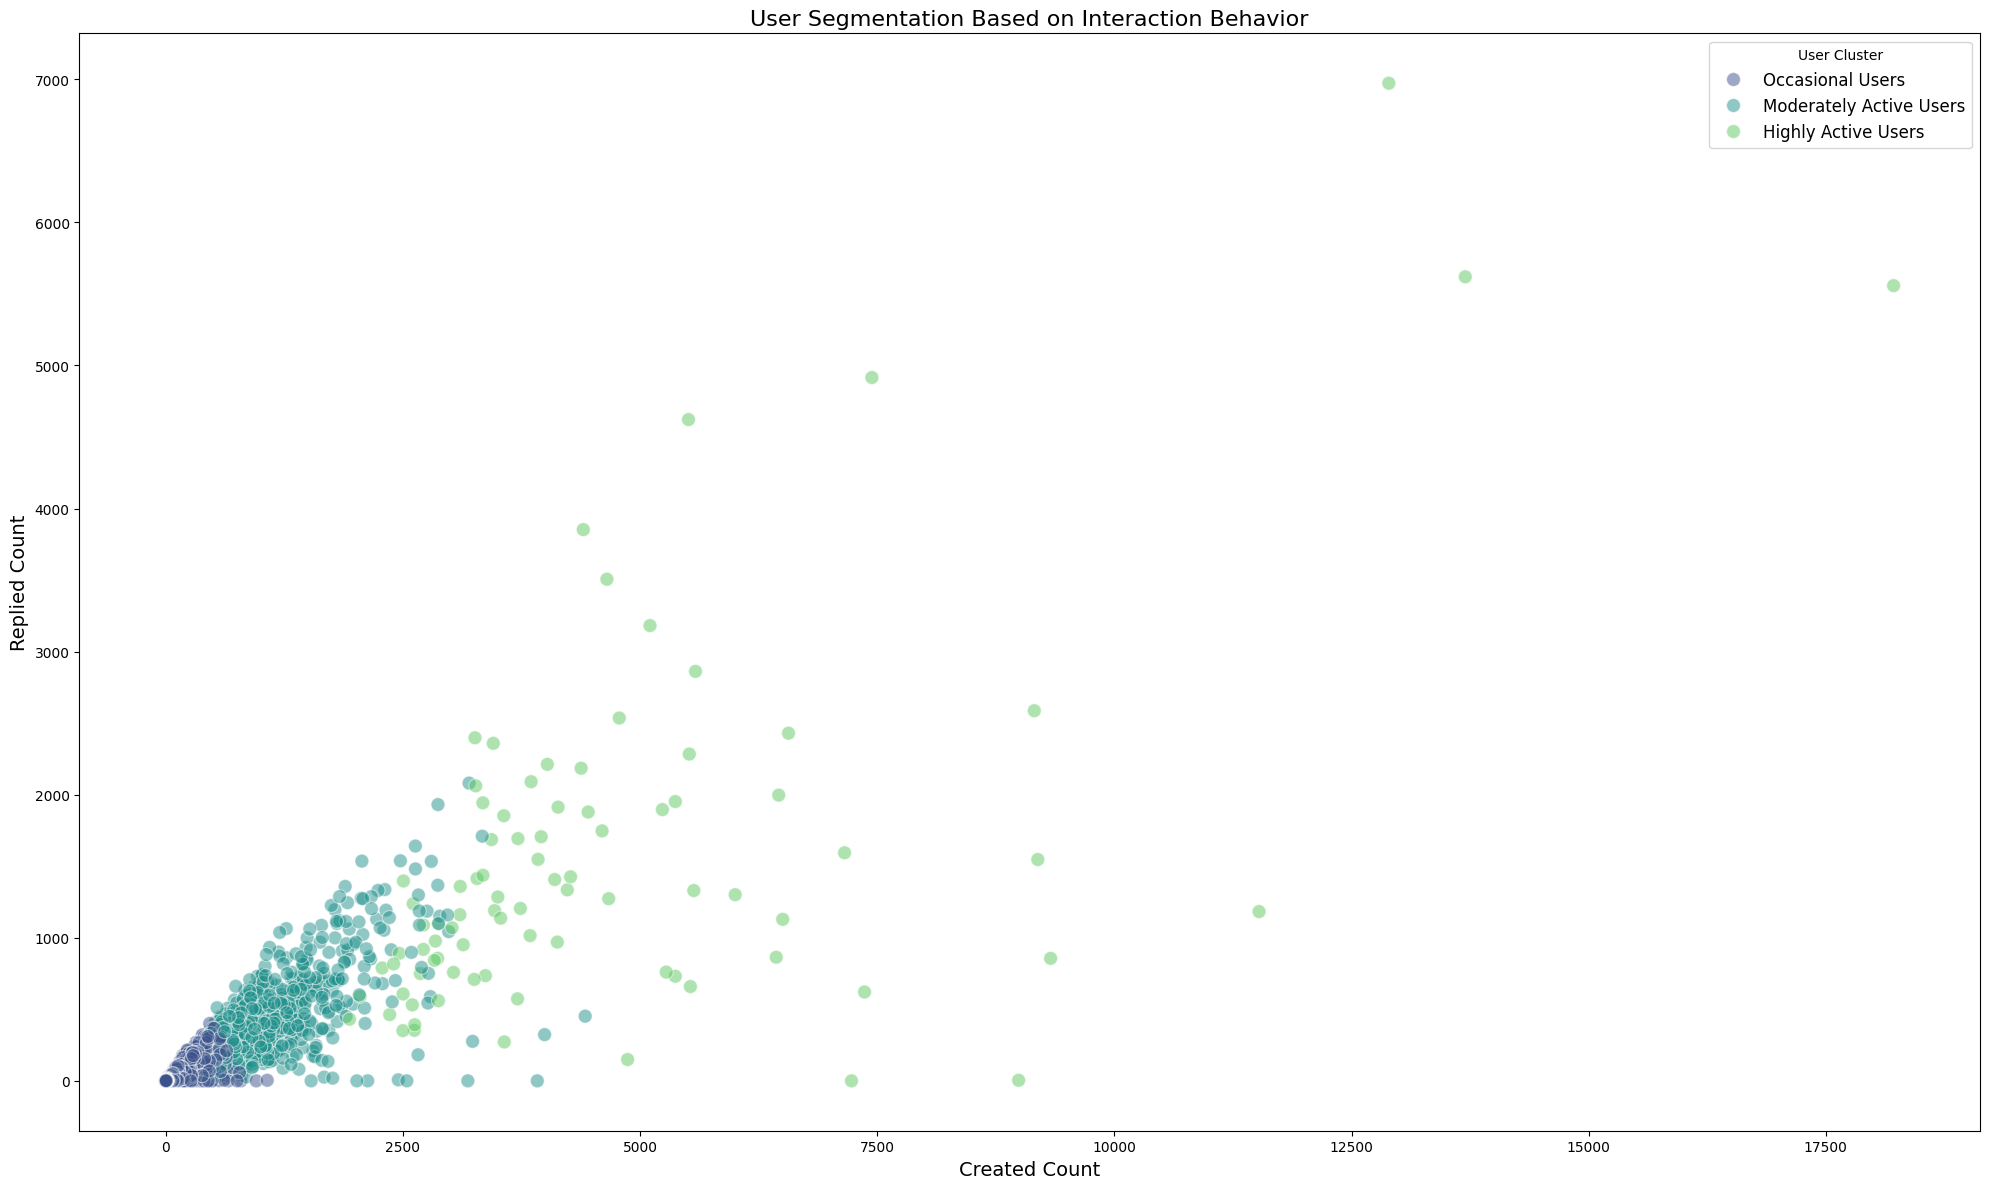

Average Interactions by Cluster:
                         avg_created  avg_reposted  avg_quoted  avg_replied  \
cluster_label                                                                 
Highly Active Users      4699.670455    967.193182  230.136364  1561.409091   
Moderately Active Users   946.581172    199.900096   52.169068   364.702209   
Occasional Users           20.270080      4.138711    0.815323     6.628517   

                         avg_total_interactions  
cluster_label                                    
Highly Active Users                 7458.409091  
Moderately Active Users             1563.352546  
Occasional Users                      31.852631  

Number of Users in Each Cluster:
cluster_label
Occasional Users           83627
Moderately Active Users     1041
Highly Active Users           88
Name: count, dtype: int64


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Group by 'user_id' and calculate interaction counts for each type of interaction
user_activity = bip_df.groupby('user_id').agg(
    created_count=('interaction', lambda x: (x == 'created').sum()),
    reposted_count=('interaction', lambda x: (x == 'reposted').sum()),
    quoted_count=('interaction', lambda x: (x == 'quoted').sum()),
    replied_count=('interaction', lambda x: (x == 'replied').sum()),
    total_interactions=('interaction', 'size')  # Total number of interactions (all types)
).reset_index()

# Step 2: Standardize the data (important for clustering algorithms)
scaler = StandardScaler()
user_activity_scaled = scaler.fit_transform(user_activity[['created_count', 'reposted_count', 'quoted_count', 'replied_count', 'total_interactions']])

# Step 3: Apply K-Means Clustering (Let's use 3 clusters for now)
kmeans = KMeans(n_clusters=3, random_state=42)
user_activity['cluster'] = kmeans.fit_predict(user_activity_scaled)

# Step 4: Rename clusters with descriptive labels
cluster_labels = {0: 'Moderately Active Users', 1: 'Highly Active Users', 2: 'Occasional Users'}
user_activity['cluster_label'] = user_activity['cluster'].map(cluster_labels)

# Step 5: Visualize the clusters
plt.figure(figsize=(20, 12))
sns.scatterplot(data=user_activity, x='created_count', y='replied_count', hue='cluster_label', palette='viridis', s=100, alpha=0.5)

# Customize the plot with titles and legend
plt.title('User Segmentation Based on Interaction Behavior', fontsize=16)
plt.xlabel('Created Count', fontsize=14)
plt.ylabel('Replied Count', fontsize=14)
plt.legend(title='User Cluster', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

# Step 6: Analyze the average interactions per user in each cluster
cluster_averages = user_activity.groupby('cluster_label').agg(
    avg_created=('created_count', 'mean'),
    avg_reposted=('reposted_count', 'mean'),
    avg_quoted=('quoted_count', 'mean'),
    avg_replied=('replied_count', 'mean'),
    avg_total_interactions=('total_interactions', 'mean')
)

print("Average Interactions by Cluster:")
print(cluster_averages)

# Step 7: Additional Analysis: Number of users in each cluster
cluster_counts = user_activity['cluster_label'].value_counts()
print("\nNumber of Users in Each Cluster:")
print(cluster_counts)



Other Clustering Plots

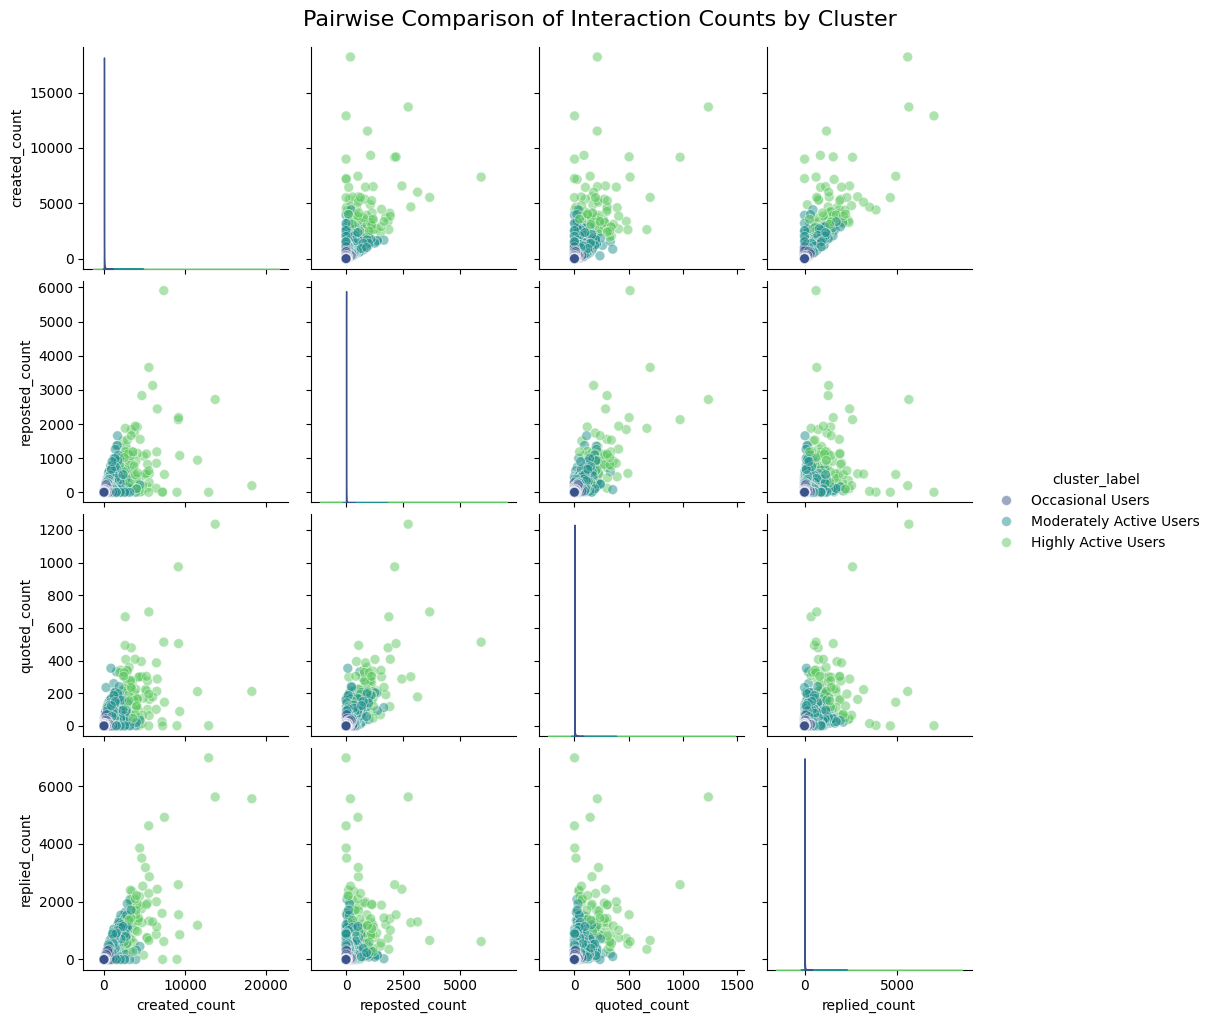

In [9]:
sns.pairplot(
    user_activity, 
    vars=['created_count', 'reposted_count', 'quoted_count', 'replied_count'],
    hue='cluster_label', 
    palette='viridis', 
    diag_kind='kde', 
    plot_kws={'alpha': 0.5, 's': 50}
)
plt.suptitle('Pairwise Comparison of Interaction Counts by Cluster', y=1.02, fontsize=16)
plt.show()


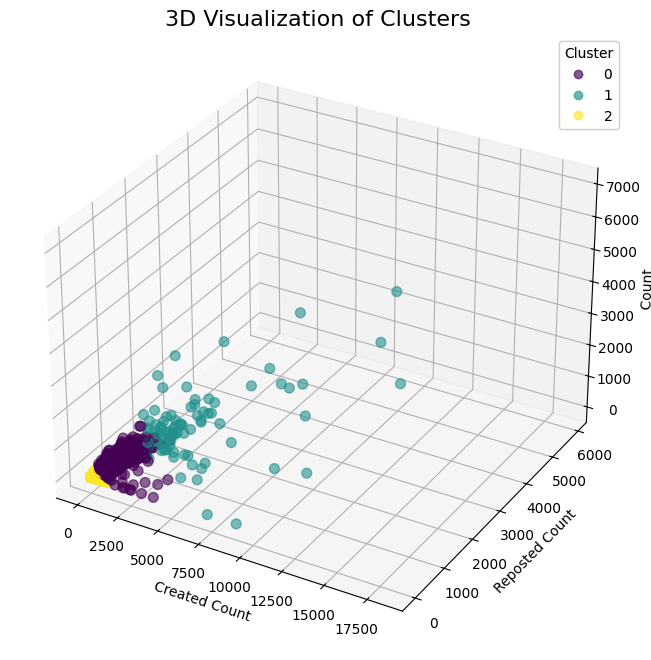

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    user_activity['created_count'], 
    user_activity['reposted_count'], 
    user_activity['replied_count'], 
    c=user_activity['cluster'], 
    cmap='viridis', 
    s=50, alpha=0.6
)
ax.set_title('3D Visualization of Clusters', fontsize=16)
ax.set_xlabel('Created Count')
ax.set_ylabel('Reposted Count')
ax.set_zlabel(' Count')
legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)
plt.show()


Engagement Rates

In [11]:
bip_df['date'] = pd.to_datetime(bip_df['date'], format='%m-%d')  # Adjust format as needed
bip_df['day_of_week'] = bip_df['date'].dt.day_name()  # Extract day of the week
bip_df['month'] = bip_df['date'].dt.month_name()  # Extract month

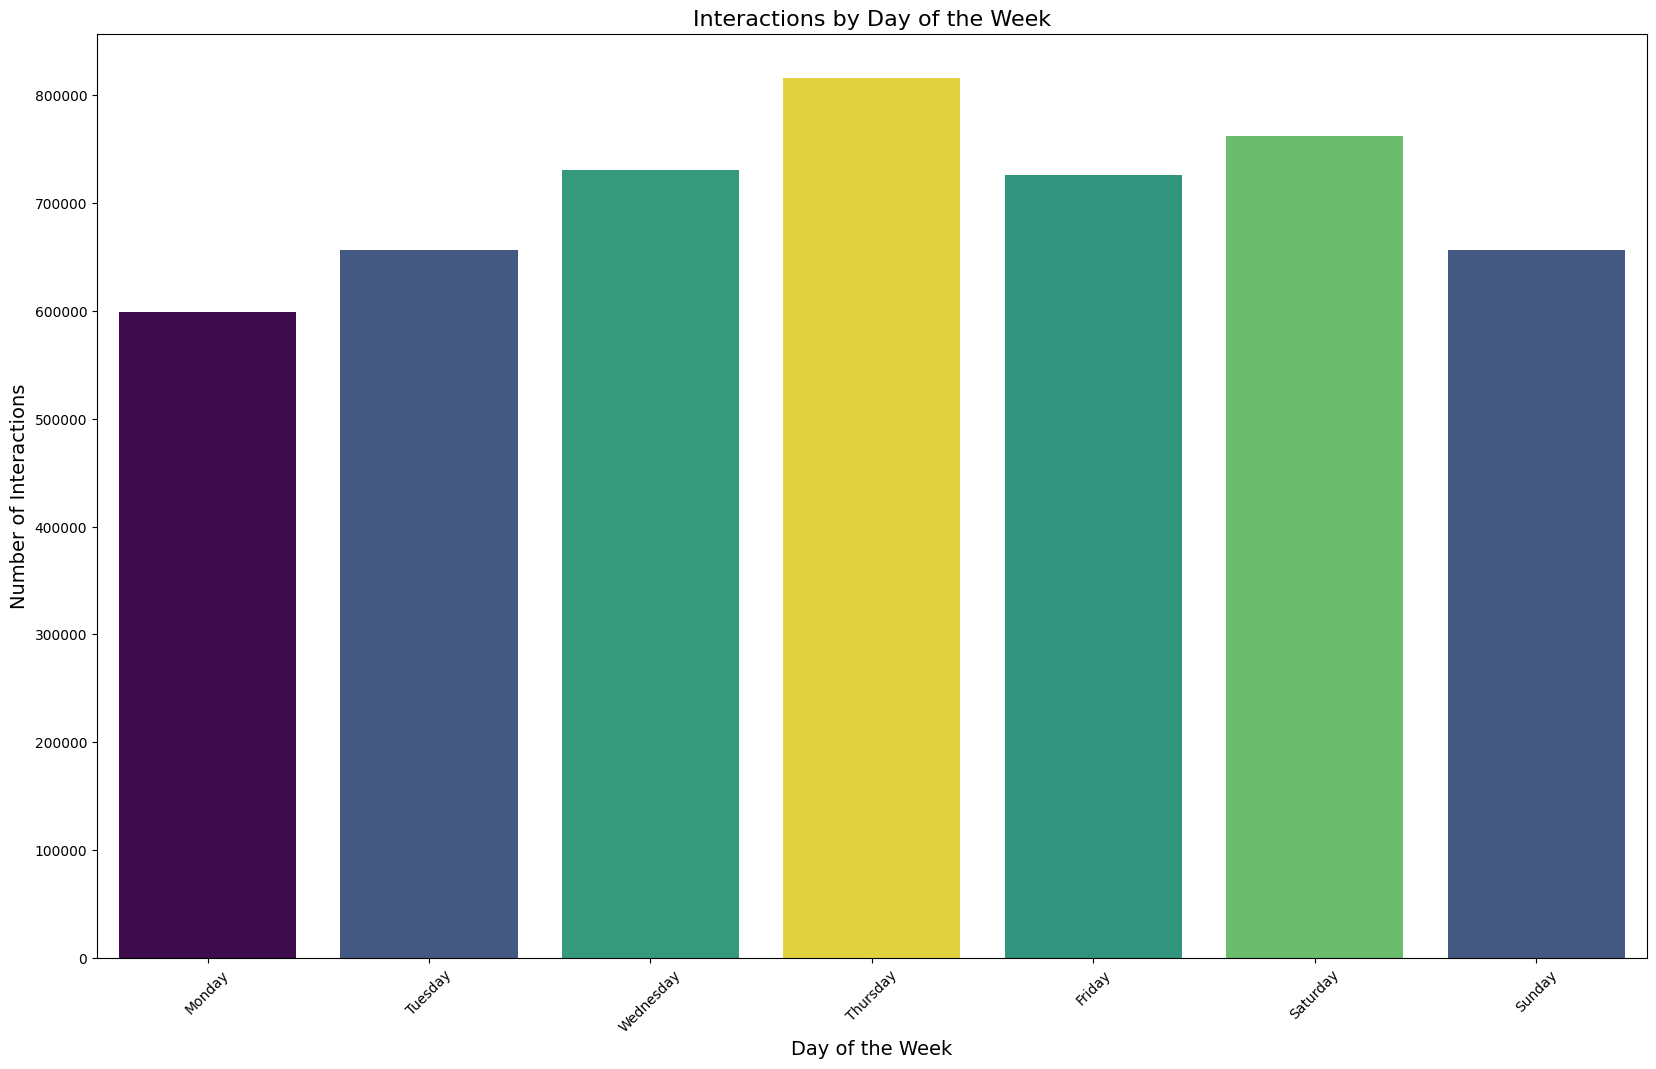

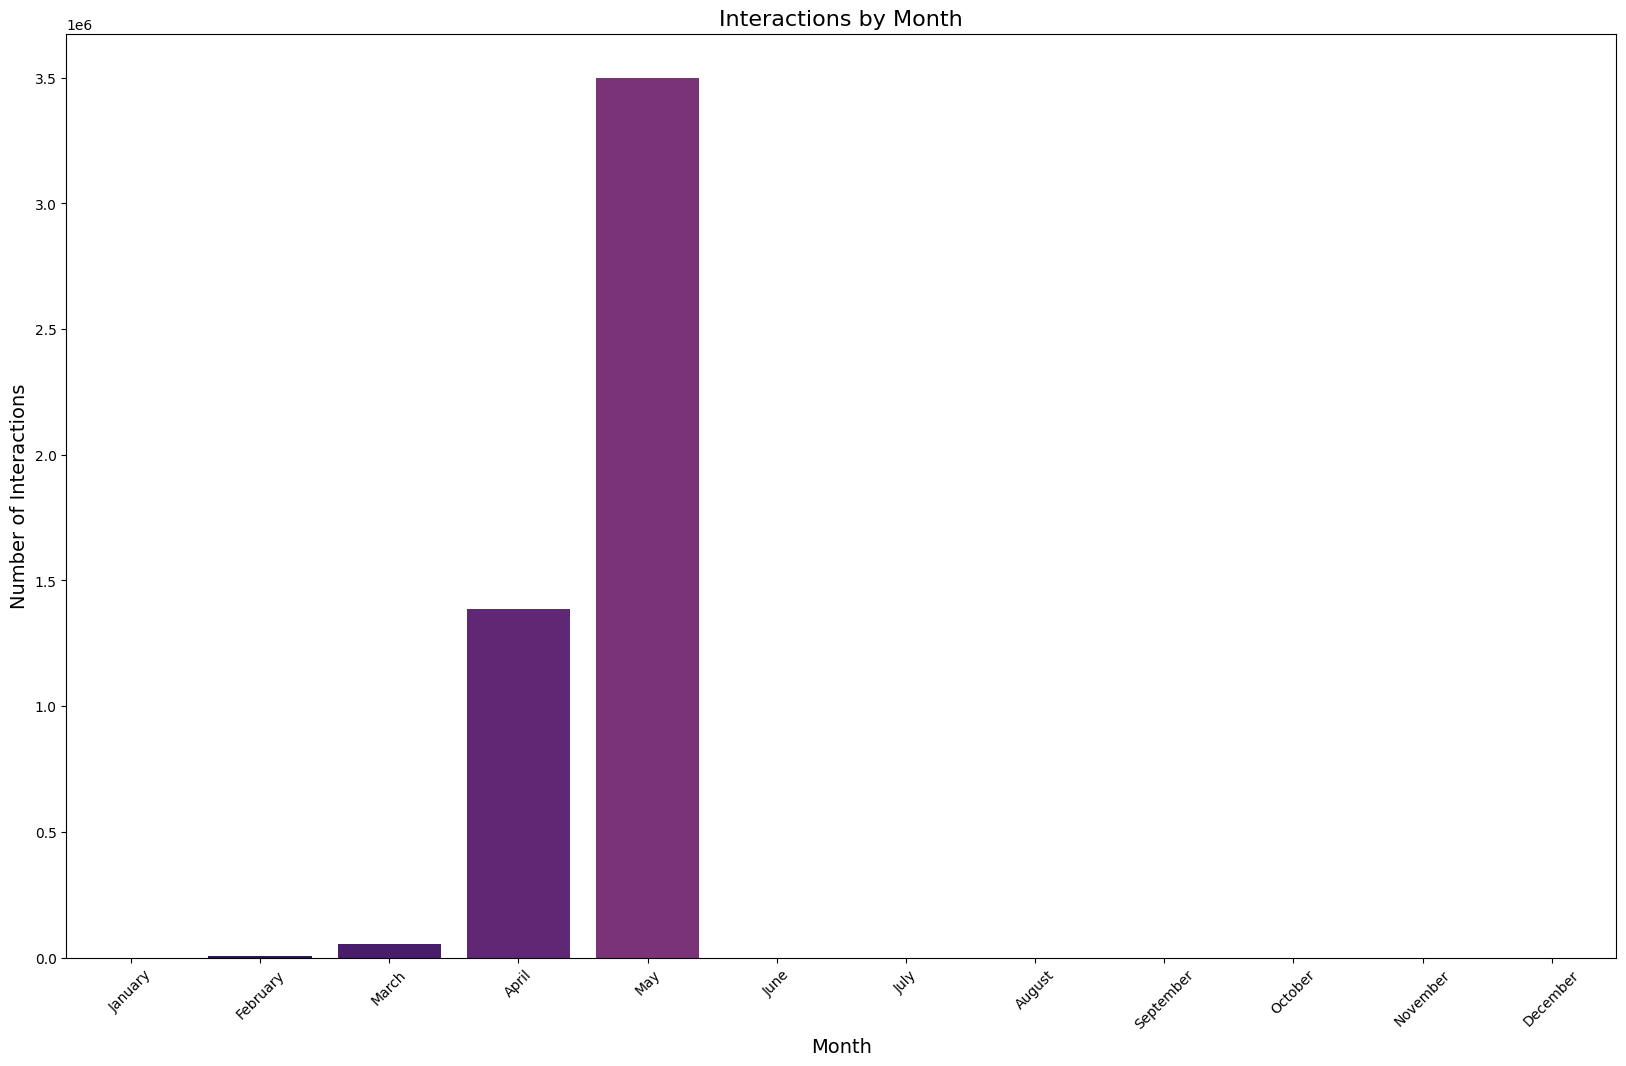

In [14]:
# Aggregate total interactions per day of the week
day_of_week_activity = bip_df.groupby('day_of_week').size().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # Ensure correct order
)

# Plot day-of-week activity
plt.figure(figsize=(20, 12))
sns.barplot(x=day_of_week_activity.index, y=day_of_week_activity.values, palette='viridis', hue= day_of_week_activity, legend=False)
plt.title('Interactions by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Aggregate total interactions per month
month_activity = bip_df.groupby('month').size().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot month activity
plt.figure(figsize=(20, 12))
sns.barplot(x=month_activity.index, y=month_activity.values, palette='magma', hue=month_activity.index, legend=False)
plt.title('Interactions by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45)
plt.show()


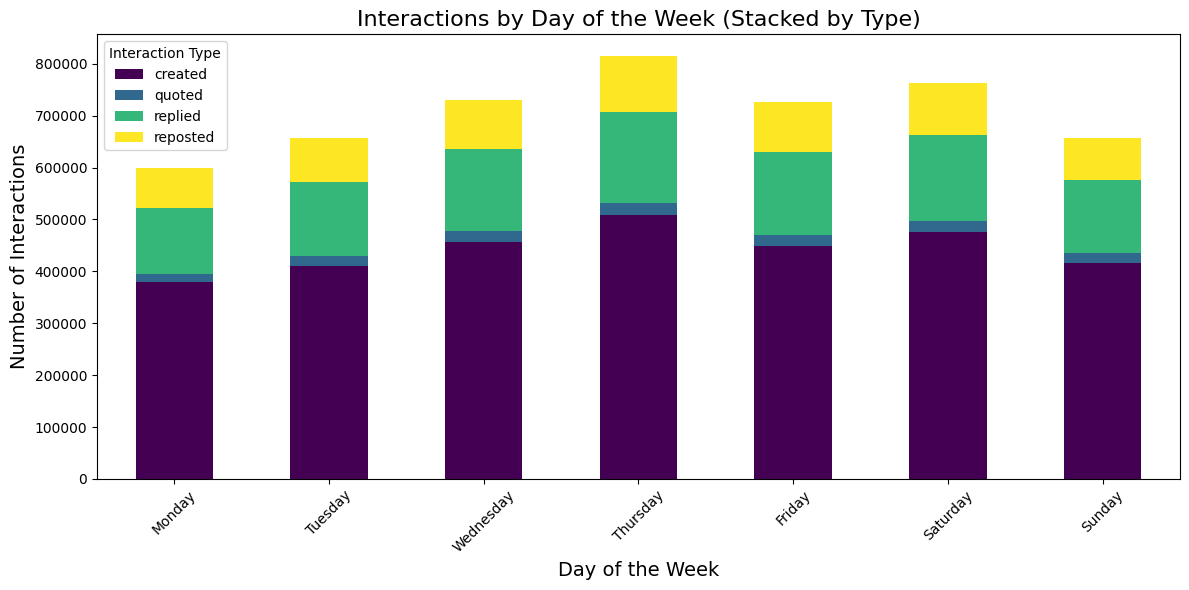

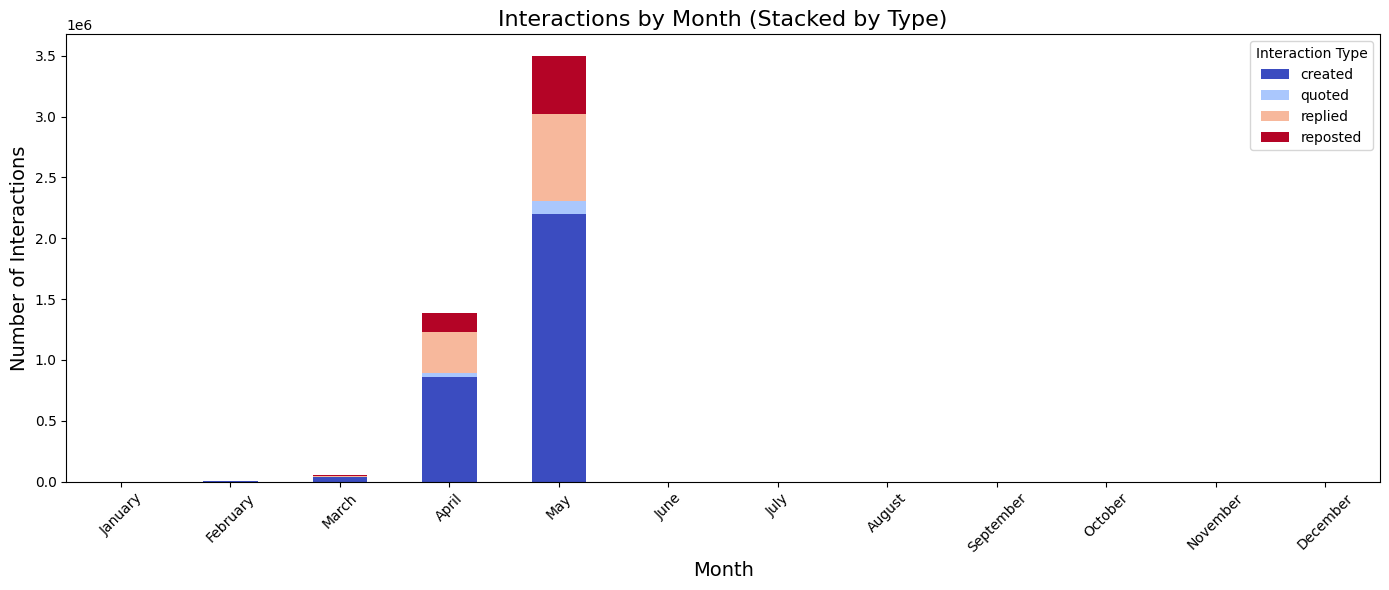

In [15]:
# Group by day of the week and interaction type
day_interaction_trends = bip_df.groupby(['day_of_week', 'interaction']).size().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot as a stacked bar chart
day_interaction_trends.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Interactions by Day of the Week (Stacked by Type)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Interaction Type')
plt.tight_layout()
plt.show()

# Similarly, for months:
month_interaction_trends = bip_df.groupby(['month', 'interaction']).size().unstack().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot as a stacked bar chart
month_interaction_trends.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='coolwarm')
plt.title('Interactions by Month (Stacked by Type)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Interaction Type')
plt.tight_layout()
plt.show()


Insights to Look For:
Day-of-week patterns:

Are interactions higher on weekdays or weekends?
Do reposts peak on specific days, indicating sharing behaviors after content creation spikes?


In [16]:
# Ensure the 'date' column is in datetime format
bip_df['date'] = pd.to_datetime(bip_df['date'], format='%m-%d')  # Adjust format if necessary

# Group by 'user_id' to get first and last interaction dates
user_engagement = bip_df.groupby('user_id').agg(
    first_interaction=('date', 'min'),
    last_interaction=('date', 'max')
).reset_index()

# Calculate the lifespan of each user's activity
user_engagement['engagement_duration'] = (user_engagement['last_interaction'] - user_engagement['first_interaction']).dt.days


Engagement Duration Summary:
count    84756.000000
mean        13.047796
std         16.601747
min          0.000000
25%          0.000000
50%          5.000000
75%         23.000000
max        103.000000
Name: engagement_duration, dtype: float64


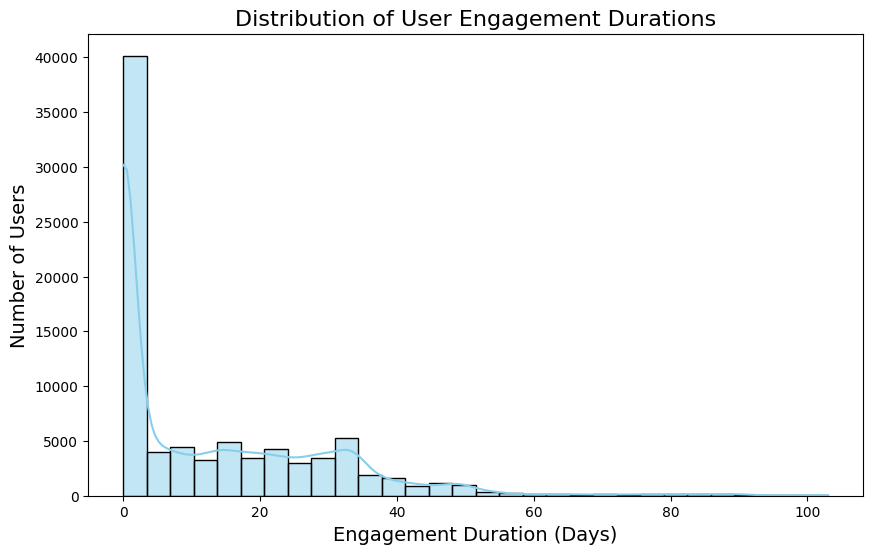

In [17]:
# Summary statistics
engagement_summary = user_engagement['engagement_duration'].describe()
print("Engagement Duration Summary:")
print(engagement_summary)

# Distribution of engagement durations
plt.figure(figsize=(10, 6))
sns.histplot(user_engagement['engagement_duration'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of User Engagement Durations', fontsize=16)
plt.xlabel('Engagement Duration (Days)', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.show()


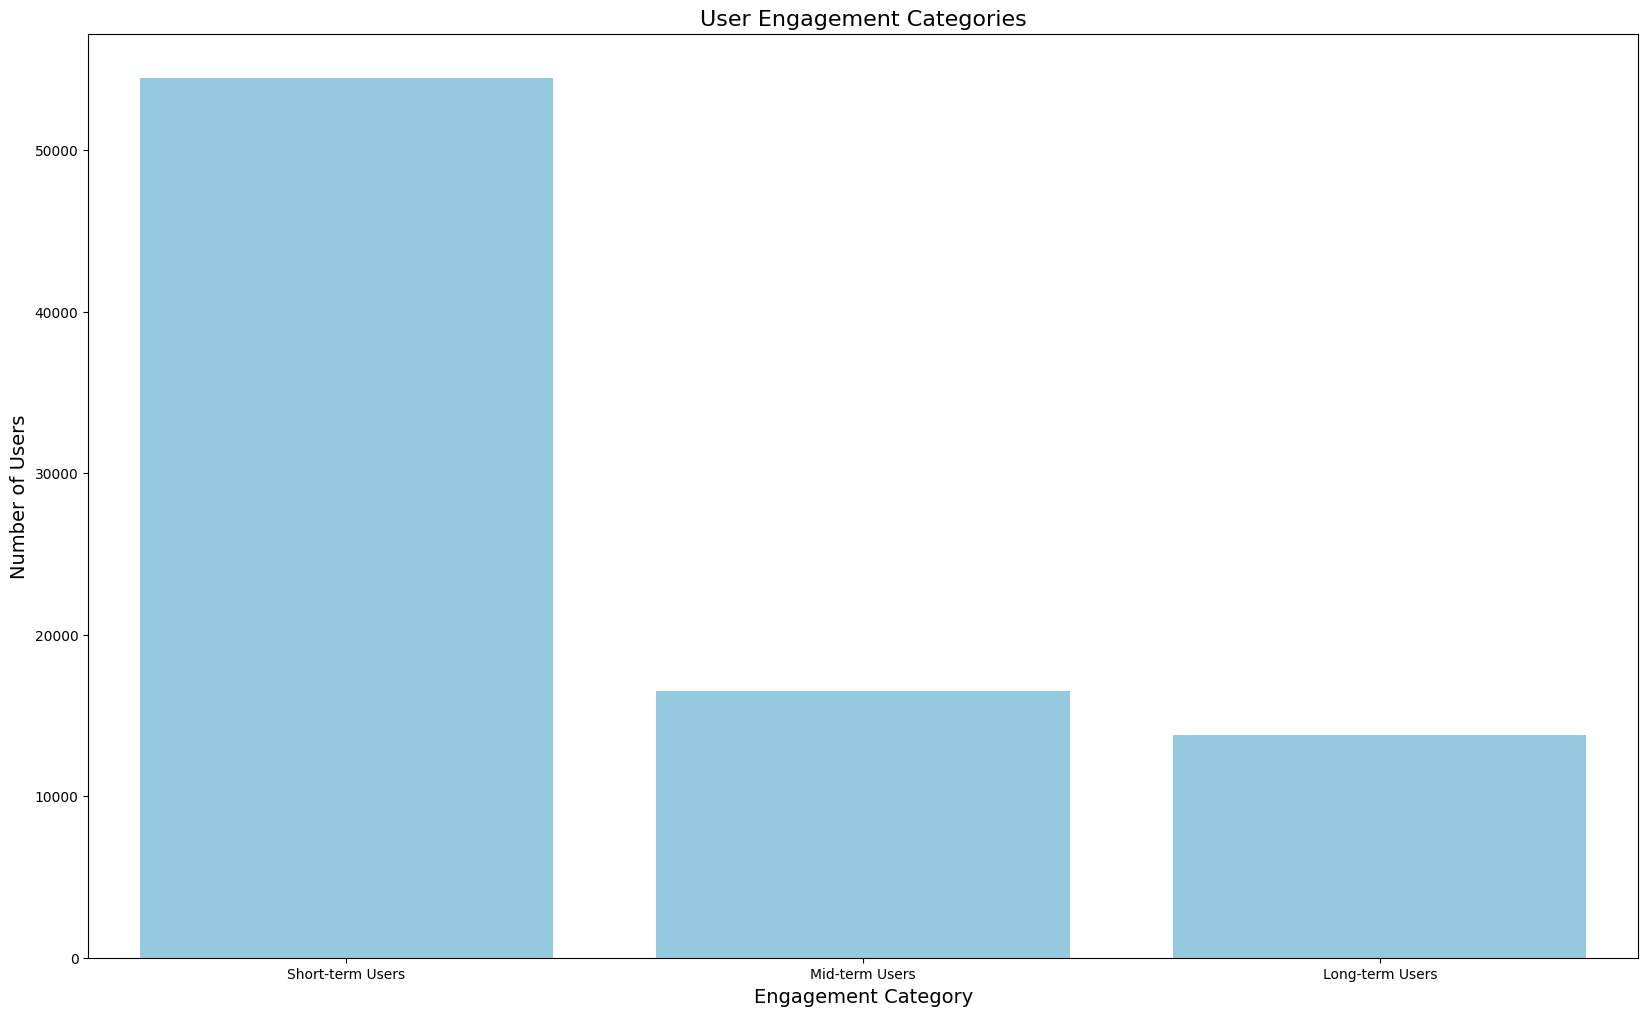

In [20]:
# Define thresholds for user segmentation 
user_engagement['engagement_category'] = pd.cut(
    user_engagement['engagement_duration'],
    bins=[-1, 15, 30, float('inf')],  # Adjust thresholds as needed
    labels=['Short-term Users', 'Mid-term Users', 'Long-term Users']
)

# Count users in each category
engagement_category_counts = user_engagement['engagement_category'].value_counts()

# Visualize the counts
plt.figure(figsize=(20, 12))
sns.barplot(x=engagement_category_counts.index, y=engagement_category_counts.values, color='skyblue')
plt.title('User Engagement Categories', fontsize=16)
plt.xlabel('Engagement Category', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.show()


Churn Rate: 45.00%


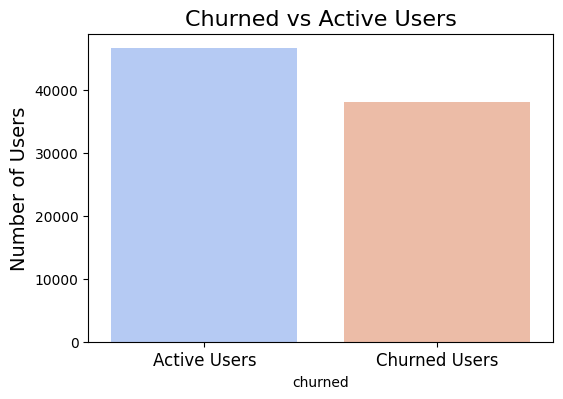

In [22]:
# Define a "churn cutoff" date
churn_cutoff_date = bip_df['date'].max() - pd.Timedelta(days=15)

# Identify users who have not interacted after the cutoff date
user_engagement['churned'] = user_engagement['last_interaction'] < churn_cutoff_date

# Calculate the churn rate
churn_rate = user_engagement['churned'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

# Count churned and active users
churn_counts = user_engagement['churned'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='coolwarm', hue=churn_counts.index, legend=False)
plt.title('Churned vs Active Users', fontsize=16)
plt.xticks([0, 1], ['Active Users', 'Churned Users'], fontsize=12)
plt.ylabel('Number of Users', fontsize=14)
plt.show()
